In [1]:
import pandas as pd
import numpy as np

Limpieza csv coste de vida:

In [2]:
def costsCleaning():
    df = pd.read_csv('../INPUT/cost_of_life_by_country.csv')
    # Renaming columns of use:
    df.rename(columns={'Meal, Inexpensive Restaurant':'restaurant',
                      'Meal for 2 People, Mid-range Restaurant, Three-course':'mid-range restaurant',
                      'McMeal at McDonalds (or Equivalent Combo Meal)':'mcdonalds',
                      'Bottle of Wine (Mid-Range)':'wine',
                      'Cigarettes 20 Pack (Marlboro)':'cigarettes',
                      'Monthly Pass (Regular Price)':'public transport',
                      'Volkswagen Golf 1.4 90 KW Trendline (Or Equivalent New Car)':'car',
                      'Internet (60 Mbps or More, Unlimited Data, Cable/ADSL)':'internet',
                      'Basic (Electricity, Heating, Cooling, Water, Garbage) for 85m2 Apartment':'utilities',
                      'Fitness Club, Monthly Fee for 1 Adult':'fitness',
                      'Cinema, International Release, 1 Seat':'cinema',
                      'Apartment (1 bedroom) in City Centre':'rent',
                      'Average Monthly Net Salary (After Tax)':'salary',
                      'Country':'country'
                     }, inplace=True)
    # Creating new column that groups all supermarket products simulating a shopping basket:
    df['supermarket'] = df['Milk (regular), (1 liter)'] + df['Loaf of Fresh White Bread (500g)'] + df['Rice (white), (1kg)'] + df['Eggs (regular) (12)'] + df['Local Cheese (1kg)'] + df['Chicken Breasts (Boneless, Skinless), (1kg)'] + df['Beef Round (1kg) (or Equivalent Back Leg Red Meat)'] + df['Apples (1kg)'] + df['Banana (1kg)'] + df['Oranges (1kg)'] + df['Tomato (1kg)'] + df['Potato (1kg)'] + df['Onion (1kg)'] + df['Lettuce (1 head)']
    # Creating final dataset:
    costs = df[['country', 'supermarket', 'restaurant', 'mid-range restaurant', 'mcdonalds', 'wine', 'cigarettes', 'rent', 'utilities', 'internet', 'fitness', 'cinema', 'public transport', 'car', 'salary']]
    # Removing Venezuela from the analysis as it is an outlier:
    costs = costs[costs.country != 'Venezuela']
    return costs

In [3]:
costs = costsCleaning()
costs.head()

,country,supermarket,restaurant,mid-range restaurant,mcdonalds,wine,cigarettes,rent,utilities,internet,fitness,cinema,public transport,car,salary
0,Kazakhstan,22.51,4.75,23.75,4.28,4.75,0.95,266.08,49.38,10.40,37.80,3.56,16.63,15439.64,376.99
1,Paraguay,21.52,3.45,20.72,3.52,5.53,1.38,220.26,44.63,25.79,22.27,4.83,21.02,11050.72,316.20
2,Portugal,33.51,7.50,30.00,6.00,4.00,5.00,619.65,96.61,31.86,32.75,7.00,35.00,25000.00,830.15
3,Syria,20.82,3.61,14.00,3.61,2.94,2.34,176.54,17.15,30.94,13.07,4.38,9.68,18027.28,83.89
4,Greece,37.29,10.00,31.00,6.00,6.25,4.50,323.04,145.67,30.81,32.34,8.00,30.00,18000.00,708.74


Limpieza csv indice felicidad:

In [4]:
def happinessCleaning():
    df = pd.read_csv('../INPUT/2019.csv')
    # Renaming columns of use:
    df.rename(columns={'Country or region':'country',
                       'Score':'happiness',
                     }, inplace=True)
    happiness = df[['country', 'happiness']]
    happiness = happiness.round({'happiness':2})
    return happiness

In [5]:
happiness = happinessCleaning()
happiness.head()

,country,happiness
0,Finland,7.77
1,Denmark,7.60
2,Norway,7.55
3,Iceland,7.49
4,Netherlands,7.49


Fusión de los csv:

In [6]:
# Incluir en la función final donde ejecute todo de una:

merged = pd.merge(costs, happiness, how='inner', on=['country'])

In [7]:
merged.head()

,country,supermarket,restaurant,mid-range restaurant,mcdonalds,wine,cigarettes,rent,utilities,internet,fitness,cinema,public transport,car,salary,happiness
0,Kazakhstan,22.51,4.75,23.75,4.28,4.75,0.95,266.08,49.38,10.40,37.80,3.56,16.63,15439.64,376.99,5.81
1,Paraguay,21.52,3.45,20.72,3.52,5.53,1.38,220.26,44.63,25.79,22.27,4.83,21.02,11050.72,316.20,5.74
2,Portugal,33.51,7.50,30.00,6.00,4.00,5.00,619.65,96.61,31.86,32.75,7.00,35.00,25000.00,830.15,5.69
3,Syria,20.82,3.61,14.00,3.61,2.94,2.34,176.54,17.15,30.94,13.07,4.38,9.68,18027.28,83.89,3.46
4,Greece,37.29,10.00,31.00,6.00,6.25,4.50,323.04,145.67,30.81,32.34,8.00,30.00,18000.00,708.74,5.29


Reorganización y preparación tabla final:

In [8]:
def mergedTable(merged):
    # Renaming column salary as it will represent the % of cost over salary:
    merged.rename(columns={'salary':'% salary'}, inplace=True)
    # Creating a MultiIndex for every cost of living related with salary and happiness score:
    cols = ['supermarket', 'restaurant', 'mid-range restaurant', 'mcdonalds', 'wine', 'cigarettes', 'rent', 'utilities', 'internet', 'fitness', 'cinema', 'public transport', 'car']
    mix = pd.MultiIndex.from_product([cols, ['% salary', 'happiness']])
    # Dividing every cost by salary:
    dfinal = round(merged[cols].div(merged['% salary'], axis=0).mul(100).reindex(mix, axis=1, level=0),2)
    idx = pd.IndexSlice
    # Reset the values from happiness score:
    dfinal.loc[:, idx[:, 'happiness']] = merged[['happiness']*len(cols)].to_numpy()
    # Including back the countries as index:
    dfinal['country'] = merged['country']
    dfinal = dfinal.set_index(['country'])
    return dfinal

In [9]:
dfinal = mergedTable(merged)
dfinal.head()

supermarket           restaurant           mid-range restaurant  \
              % salary happiness   % salary happiness             % salary   
country                                                                      
Kazakhstan        5.97      5.81       1.26      5.81                 6.30   
Paraguay          6.81      5.74       1.09      5.74                 6.55   
Portugal          4.04      5.69       0.90      5.69                 3.61   
Syria            24.82      3.46       4.30      3.46                16.69   
Greece            5.26      5.29       1.41      5.29                 4.37   

                     mcdonalds               wine            ... internet  \
           happiness  % salary happiness % salary happiness  ... % salary   
country                                                      ...            
Kazakhstan      5.81      1.14      5.81     1.26      5.81  ...     2.76   
Paraguay        5.74      1.11      5.74     1.75      5.74  ...     8.16   
Portugal        5.69      0.72      5.69     0.48      5.69  ...     3.84   
Syria           3.46      4.30      3.46     3.50      3.46  ...    36.88   
Greece          5.29      0.85      5.29     0.88      5.29  ...     4.35   

                      fitness             cinema           public transport  \
           happiness % salary happiness % salary happiness         % salary   
country                                                                       
Kazakhstan      5.81    10.03      5.81     0.94      5.81             4.41   
Paraguay        5.74     7.04      5.74     1.53      5.74             6.65   
Portugal        5.69     3.95      5.69     0.84      5.69             4.22   
Syria           3.46    15.58      3.46     5.22      3.46            11.54   
Greece          5.29     4.56      5.29     1.13      5.29             4.23   

                           car            
           happiness  % salary happiness  
country                                   
Kazakhstan      5.81   4095.50      5.81  
Paraguay        5.74   3494.85      5.74  
Portugal        5.69   3011.50      5.69  
Syria           3.46  21489.19      3.46  
Greece          5.29   2539.72      5.29  

[5 rows x 26 columns]

In [10]:
'''FILTRO PAIS + TIPO COSTE: me devuelve cuánto supone dicho coste sobre salario medio del país y el índice de 
felicidad en ese país.'''

dfinal.loc['Spain', 'wine']

% salary     0.39
happiness    6.35
Name: Spain, dtype: float64

In [11]:
'''MEDIA: cálculo de la media de cuánto supone el coste elegido sobre el salario a nivel mundia + media del índice
de felicidad.'''

mean = dfinal[['wine']].mean(axis=0)
round(mean,2)

wine  % salary     1.27
      happiness    5.89
dtype: float64

Función que compara los filtros elegidos con la media:

In [12]:
# Guardar los filtros en una variable

country = 'Spain'
cost = 'wine'

def compare(country, cost):
    filt = dfinal.loc[country, cost]
    mean = dfinal[[cost]].mean(axis=0)
    mean = round(mean,2)
    print(f'The cost of {cost} represents {filt[0]}% of the average monthly salary in {country}\n')
    print(f'The happiness score in {country} is {filt[1]}\n')
    if (filt[0] - mean[0]) > 0 and (filt[1] - mean[1]) > 0:
        return f'The cost of {cost} is {abs((filt[0] - mean[0]))}% higher than the average of 96 countries analised.\nEven so, they are happier than the average.\n'
    elif (filt[0] - mean[0]) > 0 and (filt[1] - mean[1]) < 0:
        return f'The cost of {cost} is {abs((filt[0] - mean[0]))}% higher than the average of 96 countries analised.\nFurthermore, they are less happy than the average.\n'
    elif (filt[0] - mean[0]) < 0 and (filt[1] - mean[1]) > 0:
        return f'The cost of {cost} is {abs((filt[0] - mean[0]))}% lower than the average of 96 countries analised.\nBesides, they are happier than the average.\n'
    elif (filt[0] - mean[0]) < 0 and (filt[1] - mean[1]) < 0:
        return f'The cost of {cost} is {abs((filt[0] - mean[0]))}% lower than the average of 96 countries analised.\nInstead, they are less happy than the average.\n'

print(compare(country, cost))

The cost of wine represents 0.39% of the average monthly salary in Spain

The happiness score in Spain is 6.35

The cost of wine is 0.88% lower than the average of 96 countries analised.
Besides, they are happier than the average.


Función que muestra un diagrama de dispersión para relacionar el coste elegido con el índice de felicidad para los 96 países:

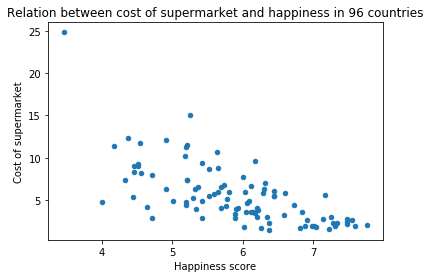

In [20]:
def scatterPlot(cost):
    plot = dfinal.plot.scatter(x=(cost,'happiness'), y=(cost,'% salary'), title=f'Relation between cost of {cost} and happiness in 96 countries')
    plot.set_xlabel('Happiness score')
    plot.set_ylabel(f'Cost of {cost}')
    return plot

scatterPlot('supermarket');

In [98]:
lista = []

for idx in df1:
    lista.append(idx)
    
print(lista)

for x in lista:
    if 'supermarket' in x:
        print(x)
        
for idx, gp in df1.groupby(level=0, axis=1):
    gp.plot.scatter(x=(idx,'happiness'), y=(idx,'salary'), title=idx)

[('supermarket', 'salary'), ('supermarket', 'happiness'), ('restaurant', 'salary'), ('restaurant', 'happiness'), ('mid-range restaurant', 'salary'), ('mid-range restaurant', 'happiness'), ('mcdonalds', 'salary'), ('mcdonalds', 'happiness'), ('wine', 'salary'), ('wine', 'happiness'), ('cigarettes', 'salary'), ('cigarettes', 'happiness'), ('rent', 'salary'), ('rent', 'happiness'), ('utilities', 'salary'), ('utilities', 'happiness'), ('internet', 'salary'), ('internet', 'happiness'), ('fitness', 'salary'), ('fitness', 'happiness'), ('cinema', 'salary'), ('cinema', 'happiness'), ('public transport', 'salary'), ('public transport', 'happiness'), ('car', 'salary'), ('car', 'happiness')]
('supermarket', 'salary')
('supermarket', 'happiness')
